Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-5-2bebb6d48a9a>:54: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-2bebb6d48a9a>:58: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/Resultados/7_1_Dendrograma_Original.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


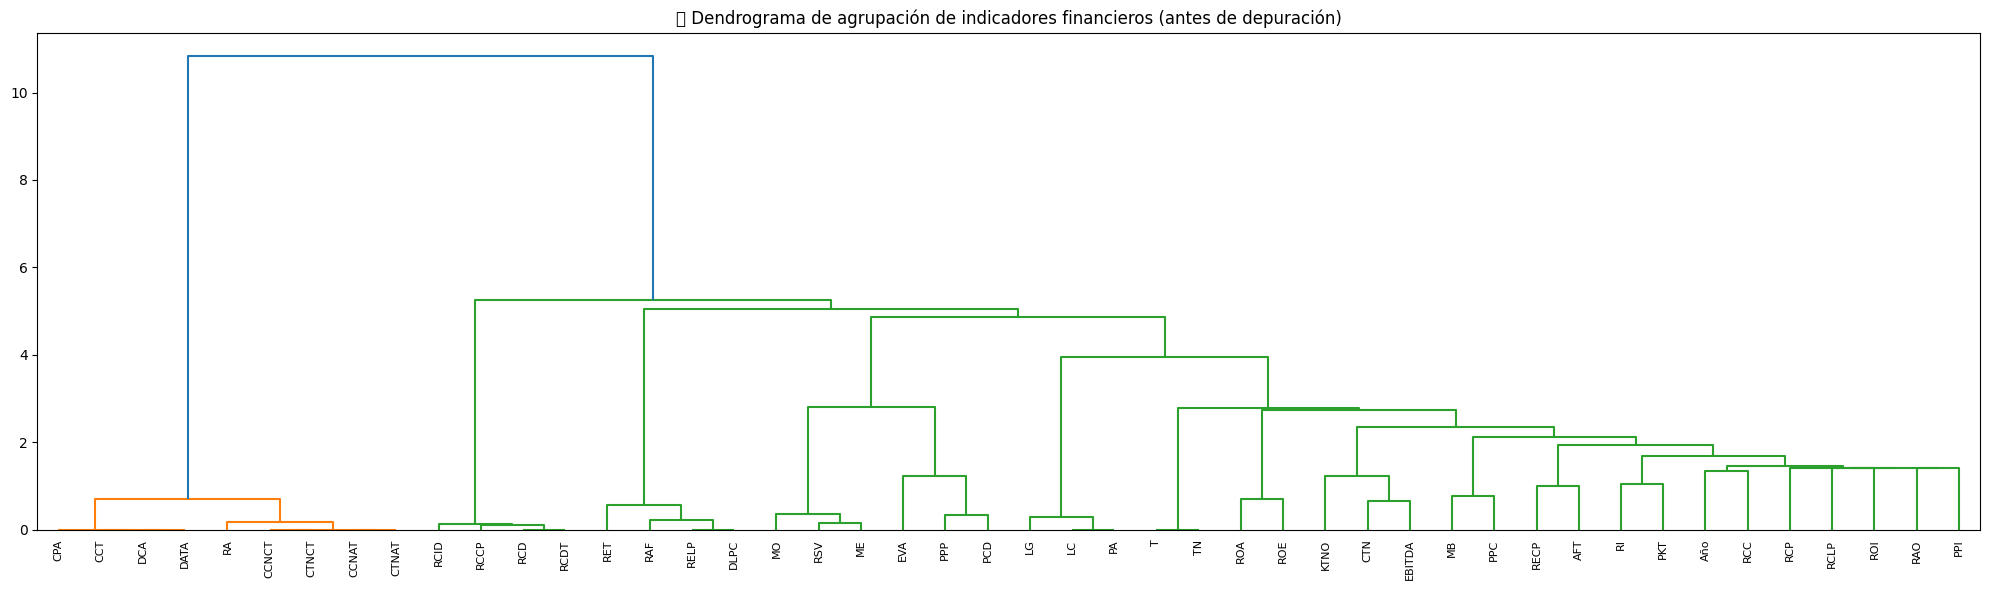

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


✅ Base reducida guardada en: /content/drive/MyDrive/Datos/7_Base_Modelos_Predictivos_Reducida.parquet


<ipython-input-5-2bebb6d48a9a>:113: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-2bebb6d48a9a>:114: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/Resultados/7_2_Dendrograma_Reducido.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


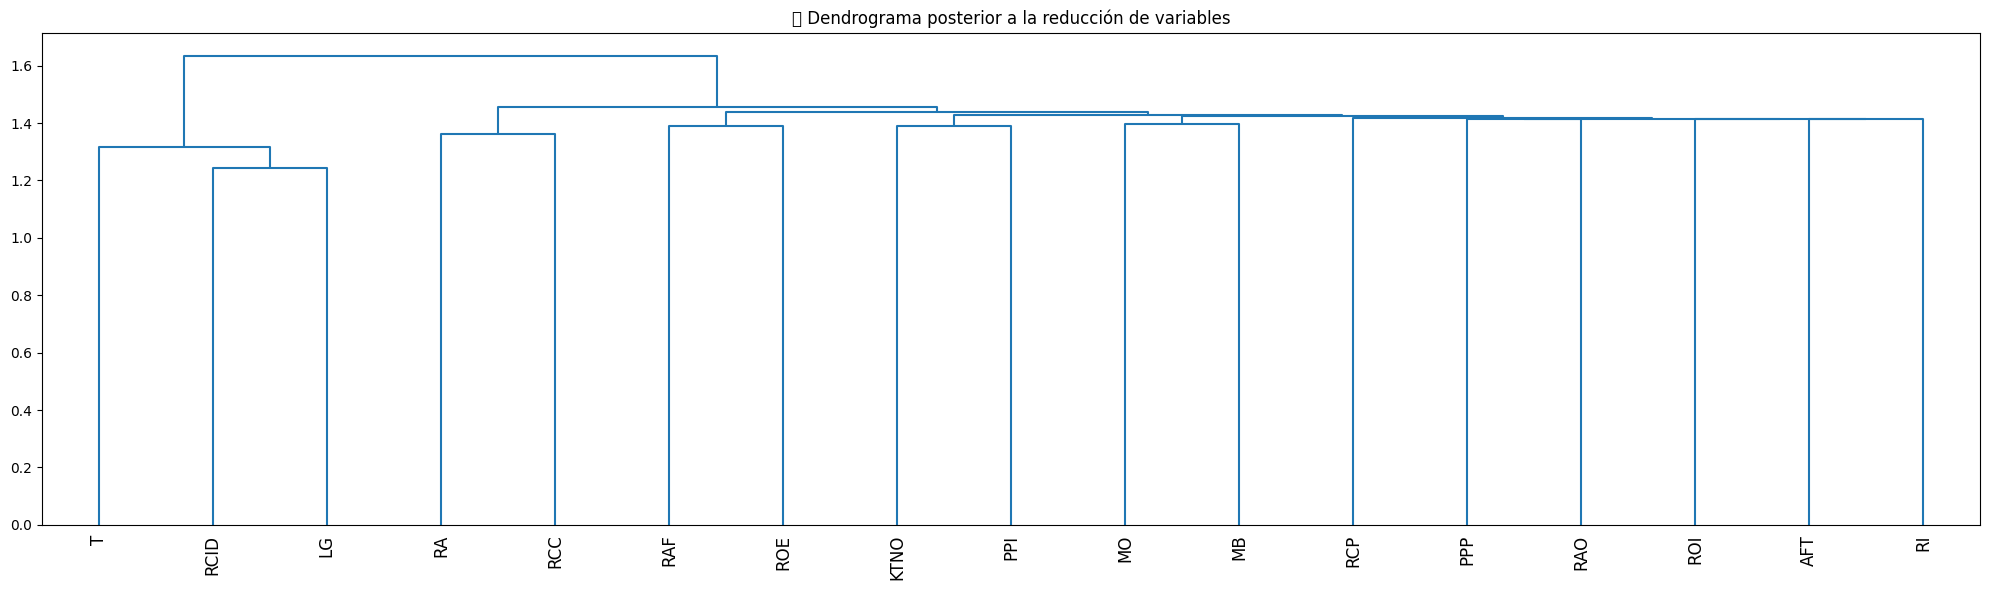

<ipython-input-5-2bebb6d48a9a>:138: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-2bebb6d48a9a>:139: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/Resultados/7_3_PCA_BaseCompleta.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


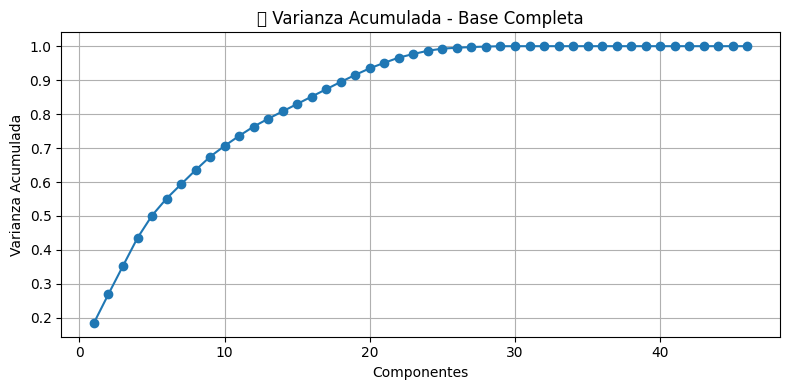

<ipython-input-5-2bebb6d48a9a>:162: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-2bebb6d48a9a>:163: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/Resultados/7_4_PCA_BaseReducida.png", dpi=600)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


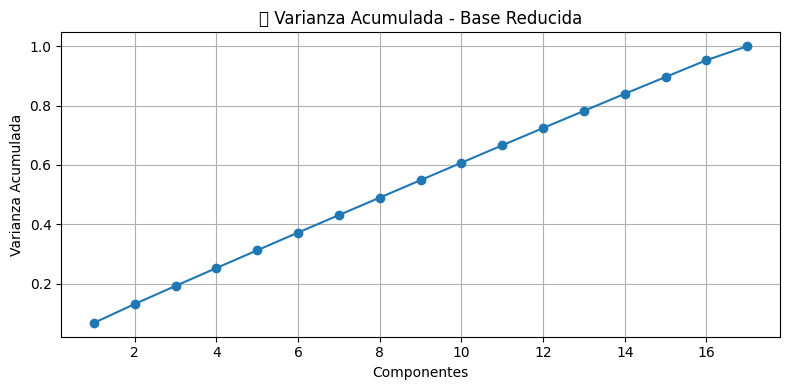

In [5]:
# 📌 Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📌 Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import os

# 📁 Cargar base original
ruta_base = "/content/drive/MyDrive/Datos/6_Base_Modelos_Predictivos.parquet"
df = pd.read_parquet(ruta_base)

# 🔒 Copia de respaldo (no se modifica)
df_original = df.copy()

# ✅ Verificar que 'RQ' está presente
assert 'RQ' in df.columns, "❌ La variable 'RQ' no está presente en la base."

# ✅ Definir variables a excluir
variables_excluir = ['NIT', 'RQ', 'DEP', 'CIIU_Letra']
variables_numericas = [col for col in df.columns if col not in variables_excluir and pd.api.types.is_numeric_dtype(df[col])]

# 📌 Subconjunto numérico para análisis (copia aparte, no modifica df_original)
df_numericas = df[variables_numericas].copy()

# ⚠️ Limpieza SOLO para análisis (reemplazo de inf y NaN)
for col in df_numericas.columns:
    if np.isinf(df_numericas[col]).any():
        valores_finitos = df_numericas.loc[np.isfinite(df_numericas[col]), col]
        df_numericas[col] = df_numericas[col].replace([np.inf], np.percentile(valores_finitos, 99))
        df_numericas[col] = df_numericas[col].replace([-np.inf], np.percentile(valores_finitos, 1))
    if df_numericas[col].isna().any():
        df_numericas[col] = df_numericas[col].fillna(df_numericas[col].median())

# 📌 Estandarización para clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numericas)
X_scaled_df = pd.DataFrame(X_scaled, columns=variables_numericas)

# 📌 Dendrograma 1 (antes de selección)
corr_matrix = X_scaled_df.corr().abs()
linked = linkage(corr_matrix, method='ward')

plt.figure(figsize=(20, 6))
dendrogram(linked, labels=variables_numericas, orientation='top', leaf_rotation=90)
plt.title("🔗 Dendrograma de agrupación de indicadores financieros (antes de depuración)")
plt.tight_layout()

# 📁 Guardar imagen
os.makedirs("/content/drive/MyDrive/Resultados", exist_ok=True)
plt.savefig("/content/drive/MyDrive/Resultados/7_1_Dendrograma_Original.png", dpi=600)
plt.show()


# 📌 Clustering y selección por VIF
n_clusters = 17
cluster_labels = fcluster(linked, t=n_clusters, criterion='maxclust')

df_grupos = pd.DataFrame({'Variable': X_scaled_df.columns, 'Grupo': cluster_labels})
vif_all = pd.DataFrame({'Variable': X_scaled_df.columns})
vif_all['VIF'] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
df_grupos = df_grupos.merge(vif_all, on='Variable')

# 📌 Seleccionar representantes
representantes = df_grupos.loc[df_grupos.groupby('Grupo')['VIF'].idxmin()].sort_values('Grupo')
variables_seleccionadas = representantes['Variable'].tolist()

# 📄 Exportar resumen de grupos y representantes
ruta_txt = "/content/drive/MyDrive/Datos/7_resumen.txt"
with open(ruta_txt, "w") as f:
    f.write("📄 Resumen de Clustering y Selección de Variables\n")
    f.write("===============================================\n\n")
    f.write("Variables seleccionadas por grupo:\n")
    for _, row in representantes.iterrows():
        grupo = row['Grupo']
        var = row['Variable']
        todas = df_grupos[df_grupos['Grupo'] == grupo]['Variable'].tolist()
        f.write(f"Grupo {grupo}: {', '.join(todas)} → Representante: {var}\n")

# 📌 Construir base reducida con inf y NaN preservados
extras = ['NIT', 'DEP', 'Año', 'RQ', 'CIIU_Letra']
df_reducida = df_original[variables_seleccionadas + extras].copy()

# 💾 Guardar base reducida
ruta_base_reducida = "/content/drive/MyDrive/Datos/7_Base_Modelos_Predictivos_Reducida.parquet"
df_reducida.to_parquet(ruta_base_reducida)
print(f"✅ Base reducida guardada en: {ruta_base_reducida}")

# 📌 Dendrograma 2 (posterior a reducción)
X_red = df_reducida[variables_seleccionadas].copy()
for col in X_red.columns:
    if np.isinf(X_red[col]).any():
        valores_finitos = X_red.loc[np.isfinite(X_red[col]), col]
        X_red[col] = X_red[col].replace([np.inf], np.percentile(valores_finitos, 99))
        X_red[col] = X_red[col].replace([-np.inf], np.percentile(valores_finitos, 1))
    if X_red[col].isna().any():
        X_red[col] = X_red[col].fillna(X_red[col].median())

X_red_scaled = StandardScaler().fit_transform(X_red)
corr_matrix_red = pd.DataFrame(X_red_scaled, columns=variables_seleccionadas).corr().abs()
linked_red = linkage(corr_matrix_red, method='ward')

plt.figure(figsize=(20, 6))
dendrogram(linked_red, labels=variables_seleccionadas, orientation='top', leaf_rotation=90)
plt.title("🔗 Dendrograma posterior a la reducción de variables")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/7_2_Dendrograma_Reducido.png", dpi=600)
plt.show()


# 📌 PCA Base completa
X_full = df_original[variables_numericas].copy()
for col in X_full.columns:
    if np.isinf(X_full[col]).any():
        valores_finitos = X_full.loc[np.isfinite(X_full[col]), col]
        X_full[col] = X_full[col].replace([np.inf], np.percentile(valores_finitos, 99))
        X_full[col] = X_full[col].replace([-np.inf], np.percentile(valores_finitos, 1))
    if X_full[col].isna().any():
        X_full[col] = X_full[col].fillna(X_full[col].median())

X_full_scaled = StandardScaler().fit_transform(X_full)
pca_full = PCA().fit(X_full_scaled)
var_exp_full = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(var_exp_full)+1), var_exp_full, marker='o')
plt.title("📈 Varianza Acumulada - Base Completa")
plt.xlabel("Componentes")
plt.ylabel("Varianza Acumulada")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/7_3_PCA_BaseCompleta.png", dpi=600)
plt.show()

# 📌 PCA Base reducida
X_sel = df_reducida[variables_seleccionadas].copy()
for col in X_sel.columns:
    if np.isinf(X_sel[col]).any():
        valores_finitos = X_sel.loc[np.isfinite(X_sel[col]), col]
        X_sel[col] = X_sel[col].replace([np.inf], np.percentile(valores_finitos, 99))
        X_sel[col] = X_sel[col].replace([-np.inf], np.percentile(valores_finitos, 1))
    if X_sel[col].isna().any():
        X_sel[col] = X_sel[col].fillna(X_sel[col].median())

X_sel_scaled = StandardScaler().fit_transform(X_sel)
pca_sel = PCA().fit(X_sel_scaled)
var_exp_sel = np.cumsum(pca_sel.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(var_exp_sel)+1), var_exp_sel, marker='o')
plt.title("📈 Varianza Acumulada - Base Reducida")
plt.xlabel("Componentes")
plt.ylabel("Varianza Acumulada")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Resultados/7_4_PCA_BaseReducida.png", dpi=600)
plt.show()
from datetime import datetime

# 📄 Exportar resumen completo de análisis
ruta_txt = "/content/drive/MyDrive/Datos/7_resumen.txt"
with open(ruta_txt, "w") as f:
    f.write("📄 Script: 7_Analisis_Exploratorio.ipynb\n")
    f.write(f"📅 Fecha: {datetime.today().strftime('%Y-%m-%d')}\n")
    f.write("🧩 Objetivo: Reducir la dimensionalidad de la base de indicadores financieros mediante clustering y VIF.\n\n")

    f.write("🔁 Pasos realizados:\n")
    f.write("- Limpieza puntual (solo para análisis) de valores NaN e infinitos.\n")
    f.write("- Cálculo de correlaciones y dendrograma jerárquico.\n")
    f.write("- Agrupamiento jerárquico en 17 clusters.\n")
    f.write("- Cálculo de VIF para selección de representantes.\n")
    f.write("- Exportación de base reducida con las 17 variables seleccionadas + columnas clave.\n")
    f.write("- Análisis PCA sobre base completa y reducida.\n\n")

    f.write("📦 Archivo generado:\n")
    f.write("- 7_Base_Modelos_Predictivos_Reducida.parquet\n\n")

    f.write("📊 Estadísticas:\n")
    f.write(f"- Variables seleccionadas: {len(variables_seleccionadas)}\n")
    f.write(f"- Columnas finales: {len(df_reducida.columns)}\n")
    f.write(f"- Registros totales: {len(df_reducida)}\n")
    f.write(f"- NITs únicos: {df_reducida['NIT'].nunique()}\n\n")

    f.write("📋 Variables seleccionadas por grupo:\n")
    for _, row in representantes.iterrows():
        grupo = row['Grupo']
        var = row['Variable']
        todas = df_grupos[df_grupos['Grupo'] == grupo]['Variable'].tolist()
        f.write(f"Grupo {grupo}: {', '.join(todas)} → Representante: {var}\n")

    f.write("\n🖼️ Gráficas exportadas:\n")
    f.write("- /Resultados/7_1_Dendrograma_Original.png\n")
    f.write("- /Resultados/7_2_Dendrograma_Reducido.png\n")
    f.write("- /Resultados/7_3_PCA_BaseCompleta.png\n")
    f.write("- /Resultados/7_4_PCA_BaseReducida.png\n")
